In [114]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [115]:
# --- Data Loading ---
def load_yield_data(filepath, target_date, interpolate=True):
    """Load and process yield curve data for a specific date with optional interpolation."""
    try:
        df = pd.read_csv(filepath)
        data_on_date = df[df['Date'] == target_date].copy()
        if data_on_date.empty:
            raise ValueError(f"No data found for date {target_date}")
        
        target_date = pd.to_datetime(target_date)
        all_maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
        
        # Filter maturities after target date
        maturities = []
        for mat in all_maturities:
            try:
                mat_date = pd.to_datetime(mat, format='%b%Y')
                if mat_date > target_date:
                    maturities.append(mat)
            except ValueError:
                continue
        
        if not maturities:
            raise ValueError(f"No valid maturities found for date {target_date}")
        
        # Convert columns to numeric
        for mat in maturities:
            time_col = f'Time_{mat}'
            yield_col = f'Yield_{mat}'
            if time_col in data_on_date.columns:
                data_on_date[time_col] = pd.to_numeric(data_on_date[time_col], errors='coerce')
            if yield_col in data_on_date.columns:
                data_on_date[yield_col] = pd.to_numeric(data_on_date[yield_col], errors='coerce')
        
        valid_cols = [f'Time_{mat}' for mat in maturities if f'Time_{mat}' in data_on_date.columns] + \
                     [f'Yield_{mat}' for mat in maturities if f'Yield_{mat}' in data_on_date.columns]
        data_on_date = data_on_date.dropna(subset=valid_cols)
        
        if data_on_date.empty:
            raise ValueError(f"No valid data after dropping NaN for date {target_date}")
        
        # Extract times and yields
        times = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
        yields = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100
        valid_idx = ~np.isnan(times) & ~np.isnan(yields)
        times, yields = times[valid_idx], yields[valid_idx]
        
        if interpolate:
            # Interpolate to a standard time grid (0.25 to 5 years)
            standard_times = np.linspace(0.25, 5.0, 20)
            if len(times) > 1:
                interp_yields = np.interp(standard_times, times, yields, left=np.nan, right=np.nan)
                valid_interp = ~np.isnan(interp_yields)
                times = standard_times[valid_interp]
                yields = interp_yields[valid_interp]
            else:
                raise ValueError(f"Insufficient valid data points for interpolation on {target_date}")
        
        return times, yields
    except Exception as e:
        raise Exception(f"Error loading data for {target_date}: {str(e)}")


In [116]:

# --- Two-Factor Vasicek Model ---
class Two_Factor_Vasicek:
    def __init__(self, x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2, rho=0.0):
        self.update_params([x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2, rho])
    
    def update_params(self, x):
        self.x1_0 = max(x[0], 0)
        self.x2_0 = max(x[1], 0)
        self.mu1 = x[2]
        self.mu2 = x[3]
        self.vol1 = max(x[4], 1e-6)
        self.vol2 = max(x[5], 1e-6)
        self.var1 = self.vol1**2
        self.var2 = self.vol2**2
        self.kappa1 = max(x[6], 1e-6)
        self.kappa2 = max(x[7], 1e-6)
        self.rho = max(min(x[8], 0.999), -0.999)  # Correlation between -1 and 1
    
    def B(self, tau, kappa):
        return (1 - np.exp(-kappa * tau)) / kappa if kappa > 1e-6 else tau
    
    def A(self, tau, mu, var, kappa):
        B_tau = self.B(tau, kappa)
        return (mu - var / (2 * kappa**2)) * (B_tau - tau) - (var * B_tau**2) / (4 * kappa)
    
    def yield_curve(self, tau, r_t):
        if tau <= 0:
            return np.nan
        A1 = self.A(tau, self.mu1, self.var1, self.kappa1)
        A2 = self.A(tau, self.mu2, self.var2, self.kappa2)
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        price = np.exp(A1 + A2 - (B1 + B2) * r_t)
        price = max(price, 1e-10)
        return -np.log(price) / tau
    
    def simulate_paths(self, T, dt, n_paths):
        n_steps = int(T / dt)
        times = np.linspace(0, T, n_steps + 1)
        r_paths = np.zeros((n_paths, n_steps + 1))
        x1 = np.zeros((n_paths, n_steps + 1))
        x2 = np.zeros((n_paths, n_steps + 1))
        x1[:, 0] = self.x1_0
        x2[:, 0] = self.x2_0
        r_paths[:, 0] = x1[:, 0] + x2[:, 0]
        
        # Generate correlated Brownian motions
        for t in range(1, n_steps + 1):
            Z1 = np.random.normal(0, 1, n_paths)
            Z2 = self.rho * Z1 + np.sqrt(1 - self.rho**2) * np.random.normal(0, 1, n_paths)
            dW1 = Z1 * np.sqrt(dt)
            dW2 = Z2 * np.sqrt(dt)
            x1[:, t] = x1[:, t-1] + self.kappa1 * (self.mu1 - x1[:, t-1]) * dt + self.vol1 * dW1
            x2[:, t] = x2[:, t-1] + self.kappa2 * (self.mu2 - x2[:, t-1]) * dt + self.vol2 * dW2
            r_paths[:, t] = np.maximum(x1[:, t] + x2[:, t], 0)
        
        return times, r_paths

In [117]:

# --- Fitter Class ---
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
        self.model_yields = None
    
    def residuals(self, x):
        self.model.update_params(x)
        r0 = self.model.x1_0 + self.model.x2_0
        model_yields = np.array([self.model.yield_curve(t, r0) for t in self.times])
        residuals = model_yields - self.data
        weights = 1 / (1 + self.times)
        weights[:3] *= 2
        weighted_residuals = residuals * weights
        
        short_term_penalty = 50 * (model_yields[0] - self.data[0])**2  # Reduced from 100
        level_penalty = 5 * (np.mean(model_yields) - np.mean(self.data))**2  # Reduced from 10
        convexity_penalty = 2 * ((model_yields[-1] - model_yields[0]) - (self.data[-1] - self.data[0]))**2  # Reduced from 5
        reg_penalty = 0.01 * np.sum(x**2)
        total_penalty = short_term_penalty + level_penalty + convexity_penalty + reg_penalty
        
        return np.append(weighted_residuals, total_penalty)
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)
        ss_res = np.sum((self.data - self.model_yields) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))
    
    def fit(self, x0, solver='trf', bounds=None):
        bounds_for_least_squares = bounds if bounds else (
            [0.005, 0.005, -np.inf, -np.inf, 0.0005, 0.0005, 0.01, 0.005, -1],  # Relaxed bounds
            [0.05, 0.05, np.inf, np.inf, 0.03, 0.03, 1.5, 0.5, 1]
        )
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds_for_least_squares)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t, self.model.x1_0 + self.model.x2_0) for t in self.times])
        return result


In [118]:

# --- Forecasting and Optimization ---
def forecast_and_optimize(model, times, initial_params, bounds, forecast_date, actual_yields, dt=1/252, n_paths=5000):
    """Forecast yields with relaxed bounds and reduced penalties."""
    forecast_days = (pd.to_datetime(forecast_date) - pd.to_datetime('2025-01-31')).days
    T = forecast_days / 365.0
    
    def objective(params):
        model.update_params(params)
        _, r_paths = model.simulate_paths(T, dt, n_paths)
        r_forecast = r_paths[:, -1]
        forecast_yields = np.array([np.mean([model.yield_curve(t, r) for r in r_forecast]) for t in times])
        
        residuals = forecast_yields - actual_yields / 100
        weights = 1 / (1 + times)
        weights[:3] *= 2
        weighted_residuals = residuals * weights
        
        slope_forecast = (forecast_yields[-1] - forecast_yields[0]) / (times[-1] - times[0])
        slope_actual = (actual_yields[-1] - actual_yields[0]) / (times[-1] - times[0])
        slope_penalty = 50 * (slope_forecast - slope_actual) ** 2  # Reduced from 200
        
        curvature_forecast = np.diff(np.diff(forecast_yields)).mean() if len(forecast_yields) > 2 else 0
        curvature_actual = np.diff(np.diff(actual_yields / 100)).mean() if len(actual_yields) > 2 else 0
        curvature_penalty = 25 * (curvature_forecast - curvature_actual) ** 2  # Reduced from 100
        
        param_penalty = 0.01 * np.sum((params - initial_params) ** 2)  # Reduced from 0.1
        
        total_error = np.sum(weighted_residuals ** 2) + slope_penalty + curvature_penalty + param_penalty
        return np.append(weighted_residuals, np.sqrt([slope_penalty, curvature_penalty, param_penalty]))
    
    # Relaxed tightened bounds
    epsilon = 1e-6  # Minimum bound width
    tightened_bounds = (
        [max(bounds[0][i], min(initial_params[i] - 0.5 * abs(initial_params[i]), initial_params[i])) for i in range(len(initial_params))],
        [min(bounds[1][i], max(initial_params[i] + 0.5 * abs(initial_params[i]), initial_params[i]) + epsilon) for i in range(len(initial_params))]
    )
    tightened_bounds = (
        [min(tightened_bounds[0][i], initial_params[i] - epsilon) for i in range(len(initial_params))],
        [max(tightened_bounds[1][i], initial_params[i] + epsilon) for i in range(len(initial_params))]
    )
    
    # Diagnostic: Print bounds and initial parameters
    print("Initial Params:", initial_params)
    print("Tightened Bounds Lower:", tightened_bounds[0])
    print("Tightened Bounds Upper:", tightened_bounds[1])
    
    result = least_squares(objective, initial_params, bounds=tightened_bounds, method='trf')
    model.update_params(result.x)
    
    _, r_paths = model.simulate_paths(T, dt, n_paths)
    r_forecast = r_paths[:, -1]
    forecast_yields = np.array([np.mean([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    forecast_std = np.array([np.std([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    
    # Diagnostic: Print forecasted yields
    print(f"Forecasted Yields for {forecast_date}:", forecast_yields * 100)
    
    return {
        'mean': forecast_yields * 100,
        'lower': (forecast_yields - 1.96 * forecast_std) * 100,
        'upper': (forecast_yields + 1.96 * forecast_std) * 100,
        'confidence': 0.95,
        'params': result.x
    }

In [119]:

def forecast_yields(model, times, forecast_date, dt=1/252, n_paths=1000):
    """Forecast yields for a future date without optimization."""
    forecast_days = (pd.to_datetime(forecast_date) - pd.to_datetime('2025-01-31')).days
    T = forecast_days / 365.0
    
    _, r_paths = model.simulate_paths(T, dt, n_paths)
    r_forecast = r_paths[:, -1]
    forecast_yields = np.array([np.mean([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    forecast_std = np.array([np.std([model.yield_curve(t, r) for r in r_forecast]) for t in times])
    
    return {
        'mean': forecast_yields * 100,
        'lower': (forecast_yields - 1.96 * forecast_std) * 100,
        'upper': (forecast_yields + 1.96 * forecast_std) * 100,
        'confidence': 0.95
    }


In [120]:

# --- Metrics Calculation ---
def calculate_metrics(observed, predicted):
    """Calculate RMSE and R-squared for observed vs predicted yields."""
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    y_mean = np.mean(observed)
    ss_tot = np.sum((observed - y_mean) ** 2)
    ss_res = np.sum((observed - predicted) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    return rmse, r2


In [121]:

# --- Plotting ---
def plot_yield_comparison(times, yields=None, fitted=None, forecast=None, historical=None,
                          metrics_text=None, title=None, figsize=(12, 8), dpi=100):
    plt.figure(figsize=figsize, dpi=dpi)
    sorted_idx = np.argsort(times)
    times_sorted = times[sorted_idx]
    
    if yields is not None:
        plt.plot(times_sorted, yields[sorted_idx], 'o-', label='Observed Yields', color='#1f77b4', linewidth=2)
    if fitted is not None:
        plt.plot(times_sorted, fitted[sorted_idx], 's--', label='Fitted Yields', color='#d62728', linewidth=2)
    if forecast is not None:
        fcst_mean = forecast['mean'][sorted_idx]
        plt.plot(times_sorted, fcst_mean, 'D-', label='Forecasted Yields', color='#2ca02c', linewidth=2)
        if 'lower' in forecast and 'upper' in forecast:
            plt.fill_between(times_sorted, forecast['lower'][sorted_idx], forecast['upper'][sorted_idx],
                            color='#2ca02c', alpha=0.15, label=f"{forecast['confidence']*100}% Confidence Band")
    if historical is not None:
        for series in historical:
            hist_times = series['times'][np.argsort(series['times'])]
            hist_yields = series['yields'][np.argsort(series['times'])]
            plt.plot(hist_times, hist_yields, series.get('marker', 'o'), label=series.get('label'), 
                     color=series.get('color', '#7f7f7f'), markersize=8, linestyle='none')
    
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield (%)')
    plt.title(title or 'Yield Curve Comparison')
    plt.legend(loc='best')
    if metrics_text:
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.grid(True)
    plt.show()


In [122]:
# --- Main Execution ---
filepath = '/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv'
dates = ['2025-01-31', '2025-02-04', '2025-03-04', '2025-04-04']
data = {date: load_yield_data(filepath, date, interpolate=False) for date in dates}
times_jan31, yields_jan31 = data['2025-01-31']
times_feb04, yields_feb04 = data['2025-02-04']
times_mar04, yields_mar04 = data['2025-03-04']
times_apr04, yields_apr04 = data['2025-04-04']

# Initial parameters and bounds
x0 = [0.02, 0.02, 0.025, 0.025, 0.01, 0.01, 0.5, 0.1, 0.0]
bounds = (
    [0.005, 0.005, -0.05, -0.05, 0.0005, 0.0005, 0.01, 0.005, -0.9],
    [0.05, 0.05, 0.05, 0.05, 0.03, 0.03, 1.5, 0.5, 0.9]
)

Jan 31 Fit Metrics:
$R^2$: 0.70
RMSE: 0.11%
Jan 31 Times: [ 0.53661875  1.53593429  2.53524983  3.53730322  4.53661875  5.53593429
  6.53524983  7.53730322  8.53661875  9.53593429 14.53524983  0.04106776
  1.0403833   2.03969884  3.03901437  4.04106776  6.03969884  7.03901437
  8.04106776  9.0403833  11.03901437 12.04106776 13.0403833  14.03969884
  0.28473648  1.28405202  2.28336756  3.28542094  4.28473648  5.28405202
  6.28336756  7.28542094  8.28473648  9.28405202 12.28473648 13.28405202
 14.28336756  0.78850103  1.78781656  2.7871321   3.78918549  5.78781656
  6.7871321   7.78918549  8.78850103  9.78781656]
Jan 31 Yields: [3.694 4.066 4.158 4.157 4.294 4.368 4.425 4.457 4.493 4.525 4.701 4.159
 4.1   3.948 4.246 4.176 4.379 4.444 4.477 4.515 4.402 4.489 4.589 4.639
 4.221 4.208 4.214 4.258 4.304 4.332 4.409 4.447 4.487 4.517 4.524 4.582
 4.688 4.22  3.867 4.172 4.278 4.363 4.44  4.442 4.493 4.531]
Jan 31 Fitted Yields: [3.98155135 4.04668473 4.11053002 4.17328622 4.23463895 4.29478

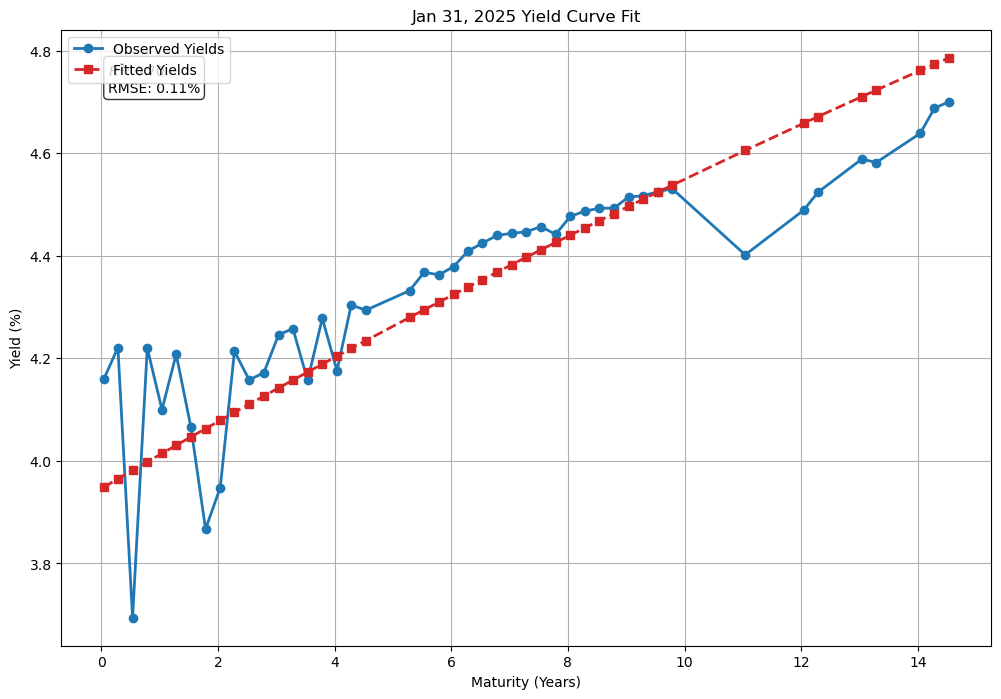

In [123]:
# Fit Jan 31
model = Two_Factor_Vasicek(*x0)  
fitter = Fitter(model, yields_jan31 / 100, times_jan31)
fit_result = fitter.fit(x0, solver='trf', bounds=bounds)
fitted_yields = np.array([model.yield_curve(t, model.x1_0 + model.x2_0) for t in times_jan31]) * 100
r2_jan31 = fitter.r_squared()
rmse_jan31 = fitter.rmse() * 100
print(f"Jan 31 Fit Metrics:\n$R^2$: {r2_jan31:.2f}\nRMSE: {rmse_jan31:.2f}%")
print("Jan 31 Times:", times_jan31)
print("Jan 31 Yields:", yields_jan31)
print("Jan 31 Fitted Yields:", fitted_yields)
print("Jan 31 Optimized Params:", fit_result.x)
metrics_text_jan31 = f'$R^2$: {r2_jan31:.2f}\nRMSE: {rmse_jan31:.2f}%'

# Plot Jan 31 fit
plot_yield_comparison(
    times=times_jan31,
    yields=yields_jan31,
    fitted=fitted_yields,
    metrics_text=metrics_text_jan31,
    title='Jan 31, 2025 Yield Curve Fit'
)

Initial Params: [ 0.00986508  0.00986508  0.03709629  0.04762519  0.00060101  0.0005997
  0.0265419   0.03118731 -0.00087865]
Tightened Bounds Lower: [0.005, 0.005, 0.018548144146406844, 0.023812596456964177, 0.0005, 0.0005, 0.013270949768936585, 0.015593654409121456, -0.001317978095769693]
Tightened Bounds Upper: [0.014798626158044422, 0.014798626158275993, 0.05, 0.05, 0.0009025141170845903, 0.0009005530941397792, 0.03981384930680976, 0.046781963227364366, -0.000438326031923231]
Forecasted Yields for 2025-02-04: [3.98172476 4.04762753 4.11222156 4.1757084  4.23777025 4.29861064
 4.35825719 4.41689548 4.47423141 4.5304524  4.79582488 4.01511245
 4.0803517  4.14429733 4.2071488  4.32882655 4.38788153 4.44594001
 4.50271073 4.61297003 4.6666526  4.71915707 4.77065444 3.96490354
 4.03114098 4.09606204 4.15986934 4.2222435  4.28338914 4.34333403
 4.40226473 4.45988571 4.51638534 4.67954913 4.73180594 4.78306116
 3.9984609  4.06403094 4.12829984 4.19146807 4.3137563  4.37310622
 4.43145377 

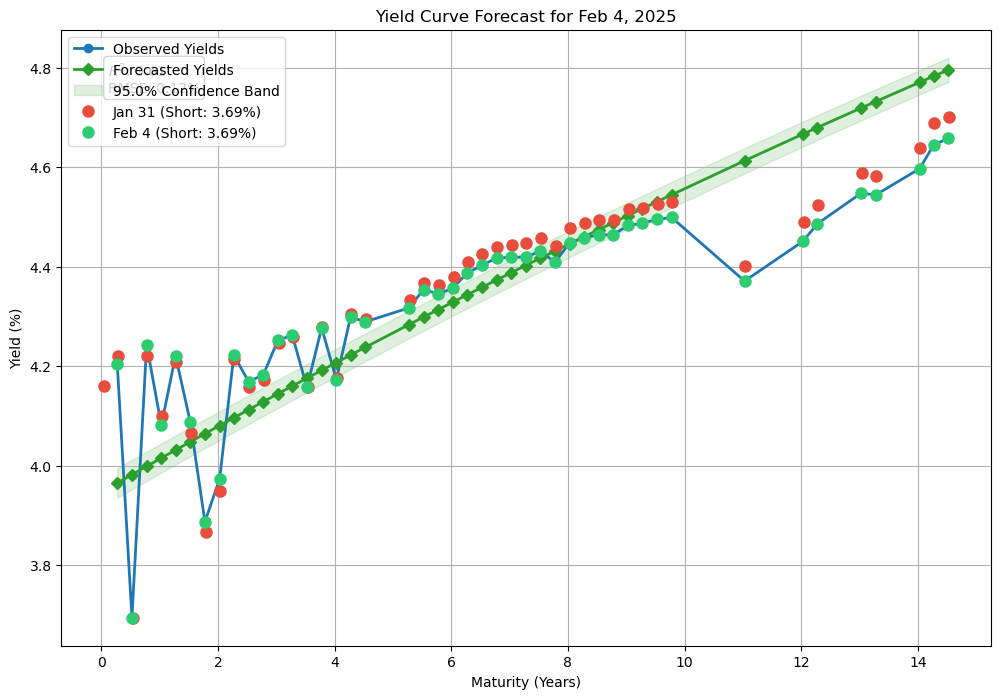

In [124]:
# Forecast and optimize for Feb 4
feb04_forecast = forecast_and_optimize(model, times_feb04, fit_result.x, bounds, '2025-02-04', yields_feb04, n_paths=5000)
rmse_feb04, r2_feb04 = calculate_metrics(yields_feb04, feb04_forecast['mean'])
print(f"Feb 4 Forecast Metrics:\n$R^2$: {r2_feb04:.2f}\nRMSE: {rmse_feb04:.2f}%")
print("Feb 4 Forecasted Yields:", feb04_forecast['mean'])
print("Feb 4 Actual Yields:", yields_feb04)
metrics_text_feb04 = f'$R^2$: {r2_feb04:.2f}\nRMSE: {rmse_feb04:.2f}%'

# Plot Feb 4 forecast
plot_yield_comparison(
    times=times_feb04,
    yields=yields_feb04,
    forecast=feb04_forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31, 'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)', 'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04, 'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)', 'color': '#2ecc71', 'marker': 'o'}
    ],
    metrics_text=metrics_text_feb04,
    title='Yield Curve Forecast for Feb 4, 2025'
)

Initial Params: [ 0.00984881  0.0098683   0.0371161   0.04793044  0.00060046  0.0005997
  0.02666855  0.03130915 -0.00087625]
Tightened Bounds Lower: [0.005, 0.005, 0.01855804911907899, 0.023965219886752098, 0.0005, 0.0005, 0.013334273427030674, 0.01565457587720307, -0.001314374610804672]
Tightened Bounds Upper: [0.014774216384984358, 0.014803442649180858, 0.05, 0.05, 0.0009016923066232094, 0.0009005544419688118, 0.04000382028109202, 0.046964727631609214, -0.00043712487026822396]
Forecasted Yields for 2025-03-04: [3.99159023 4.07376937 4.1379387  4.20100876 4.26266379 4.32310598
 4.38236273 4.44061838 4.49758074 4.55343596 4.81708951 4.04146832
 4.1062783  4.16980382 4.23224298 4.35312435 4.41179369 4.4694736
 4.52587471 4.63541774 4.68875235 4.740917   4.79208156 3.99159023
 4.05739132 4.12188537 4.18527362 4.24723876 4.30798404 4.36753704
 4.42608305 4.48332845 4.53946037 4.70156537 4.75348409 4.80440817
 4.02492645 4.09006487 4.15391136 4.21666506 4.3381526  4.3971148
 4.45508176 4.

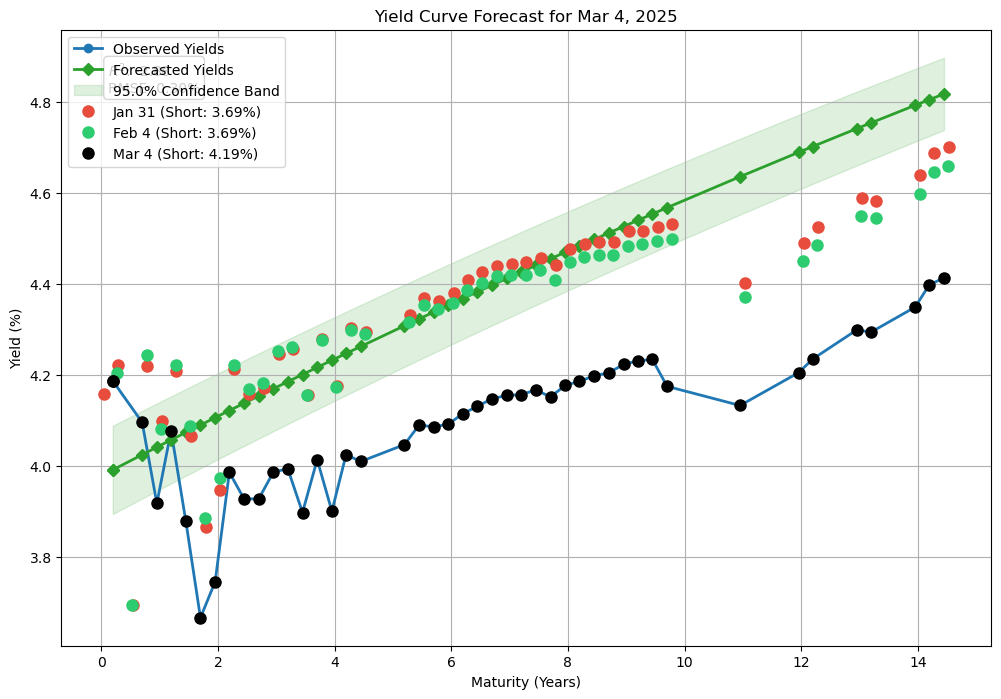

In [125]:
# Forecast and optimize for Mar 4
mar04_forecast = forecast_and_optimize(model, times_mar04, feb04_forecast['params'], bounds, '2025-03-04', yields_mar04, n_paths=5000)
rmse_mar04, r2_mar04 = calculate_metrics(yields_mar04, mar04_forecast['mean'])
print(f"Mar 4 Forecast Metrics:\n$R^2$: {r2_mar04:.2f}\nRMSE: {rmse_mar04:.2f}%")
print("Mar 4 Forecasted Yields:", mar04_forecast['mean'])
print("Mar 4 Actual Yields:", yields_mar04)
metrics_text_mar04 = f'$R^2$: {r2_mar04:.2f}\nRMSE: {rmse_mar04:.2f}%'

# Plot Mar 4 forecast
plot_yield_comparison(
    times=times_mar04,
    yields=yields_mar04,
    forecast=mar04_forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31, 'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)', 'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04, 'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)', 'color': '#2ecc71', 'marker': 'o'},
        {'times': times_mar04, 'yields': yields_mar04, 'label': f'Mar 4 (Short: {yields_mar04[0]:.2f}%)', 'color': '#000000', 'marker': 'o'}
    ],
    metrics_text=metrics_text_mar04,
    title='Yield Curve Forecast for Mar 4, 2025'
)

Initial Params: [ 0.00985236  0.00987185  0.03711028  0.04792399  0.00060076  0.00059995
  0.02665307  0.03127116 -0.00087657]
Tightened Bounds Lower: [0.005, 0.005, 0.01855513991717236, 0.02396199616032555, 0.0005, 0.0005, 0.013326535210273565, 0.015635578403053286, -0.0013148483629800657]
Tightened Bounds Upper: [0.014779541016488823, 0.014808780347499597, 0.05, 0.05, 0.0009021374466617092, 0.000900920832069507, 0.0399806056308207, 0.04690773520915986, -0.00043728278766002183]
Forecasted Yields for 2025-04-04: [4.02092078 4.10242999 4.16607691 4.22863414 4.28978847 4.34974039
 4.40851708 4.46630135 4.52280336 4.57820773 4.83974072 4.07039213
 4.13467418 4.19768285 4.25961463 4.3795155  4.43770983 4.49492331
 4.55086887 4.65952876 4.71243417 4.76417954 4.81493335 4.02092078
 4.08618537 4.15015421 4.21302688 4.27448865 4.33474106 4.39381144
 4.45188358 4.5086662  4.56434489 4.72514415 4.77664569 4.82716108
 4.05398511 4.11859277 4.18191964 4.24416324 4.36466506 4.42314973
 4.48064779 4

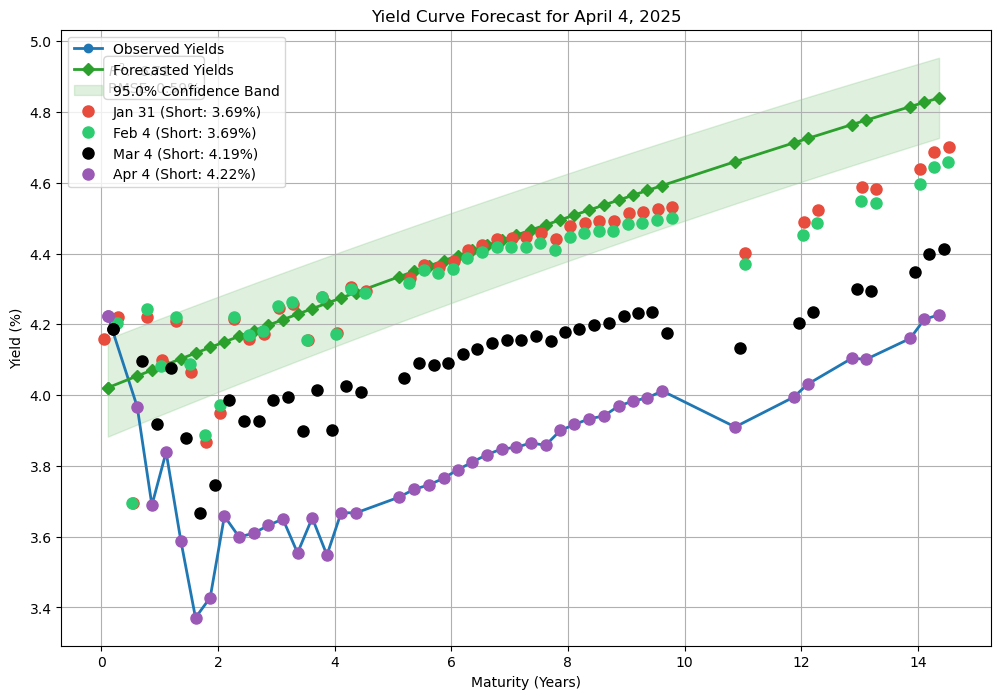

In [126]:
# Forecast and optimize for Apr 4
apr04_forecast = forecast_and_optimize(model, times_apr04, mar04_forecast['params'], bounds, '2025-04-04', yields_apr04, n_paths=5000)
rmse_apr04, r2_apr04 = calculate_metrics(yields_apr04, apr04_forecast['mean'])
print(f"Apr 4 Forecast Metrics:\n$R^2$: {r2_apr04:.2f}\nRMSE: {rmse_apr04:.2f}%")
metrics_text_apr04 = f'$R^2$: {r2_apr04:.2f}\nRMSE: {rmse_apr04:.2f}%'

# Plot Apr 4 forecast
plot_yield_comparison(
    times=times_apr04,
    yields=yields_apr04,
    forecast=apr04_forecast,
    historical=[
        {'times': times_jan31, 'yields': yields_jan31, 'label': f'Jan 31 (Short: {yields_jan31[0]:.2f}%)', 'color': '#e74c3c', 'marker': 'o'},
        {'times': times_feb04, 'yields': yields_feb04, 'label': f'Feb 4 (Short: {yields_feb04[0]:.2f}%)', 'color': '#2ecc71', 'marker': 'o'},
        {'times': times_mar04, 'yields': yields_mar04, 'label': f'Mar 4 (Short: {yields_mar04[0]:.2f}%)', 'color': '#000000', 'marker': 'o'},
        {'times': times_apr04, 'yields': yields_apr04, 'label': f'Apr 4 (Short: {yields_apr04[0]:.2f}%)', 'color': '#9b59b6', 'marker': 'o'}
    ],
    metrics_text=metrics_text_apr04,
    title='Yield Curve Forecast for April 4, 2025'
)

In [127]:
# Print diagnostics
print("Jan 31 Params:", fit_result.x)
print("Feb 4 Params:", feb04_forecast['params'])
print("Mar 4 Params:", mar04_forecast['params'])
print("Apr 4 Params:", apr04_forecast['params'])
print("Mar 4 Times:", times_mar04)
print("Mar 4 Yields:", yields_mar04)
print("Apr 4 Times:", times_apr04)
print("Apr 4 Yields:", yields_apr04)

Jan 31 Params: [ 0.00986508  0.00986508  0.03709629  0.04762519  0.00060101  0.0005997
  0.0265419   0.03118731 -0.00087865]
Feb 4 Params: [ 0.00984881  0.0098683   0.0371161   0.04793044  0.00060046  0.0005997
  0.02666855  0.03130915 -0.00087625]
Mar 4 Params: [ 0.00985236  0.00987185  0.03711028  0.04792399  0.00060076  0.00059995
  0.02665307  0.03127116 -0.00087657]
Apr 4 Params: [ 0.00986207  0.00988165  0.03706486  0.04791864  0.000601    0.00060027
  0.02660954  0.03123922 -0.00087667]
Mar 4 Times: [ 0.19712526  1.44832307  2.4476386   3.44969199  4.44900753  5.44832307
  6.4476386   7.44969199  8.44900753  9.44832307 14.4476386   0.95277207
  1.95208761  2.95140315  3.95345654  5.95208761  6.95140315  7.95345654
  8.95277207 10.95140315 11.95345654 12.95277207 13.95208761  0.19712526
  1.19644079  2.19575633  3.19780972  4.19712526  5.19644079  6.19575633
  7.19780972  8.19712526  9.19644079 12.19712526 13.19644079 14.19575633
  0.7008898   1.70020534  2.69952088  3.70157426  